In [39]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [40]:
csv_path_train = 'trainset/J0003_0024_0222_20110307012737_cell_1.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [41]:
df.head()

,CellNo,Resistance,Volt,Temp
0,1,0.259,2.23,-20
1,1,0.260,2.23,-20
2,1,0.259,2.23,-20
3,1,0.259,2.23,-20
4,1,0.259,2.23,-20


In [42]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


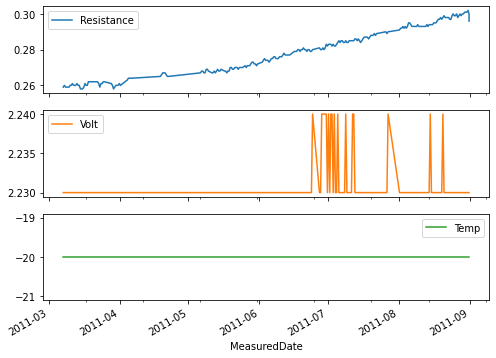

In [43]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

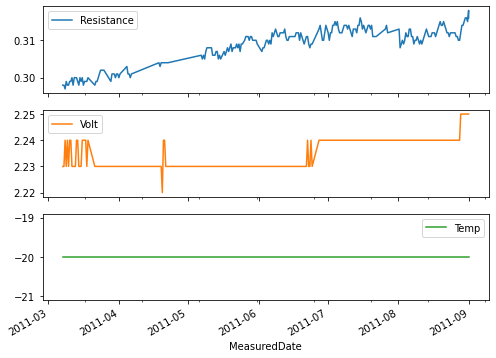

In [44]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [45]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,259.0,1.000000,0.000000,1.000,1.000,1.000,1.0000,1.000
Resistance,259.0,0.278544,0.012893,0.258,0.268,0.279,0.2895,0.302
Volt,259.0,2.230656,0.002481,2.230,2.230,2.230,2.2300,2.240
Temp,259.0,-20.000000,0.000000,-20.000,-20.000,-20.000,-20.0000,-20.000


In [46]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [47]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [48]:
xcolumn = ['Resistance','Volt','Temp']
ycolumn = ['Resistance']

trainX = df[xcolumn]
trainY = df[ycolumn]

testX = df_test[xcolumn]
testY = df_test[ycolumn]

num_features = df.shape[1]

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(trainX, trainY, test_size=0.2)


x_test, x_label, y_test, y_label = train_test_split(testX, testY, test_size=0.3)

In [50]:
def create_sequences1(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [82]:
seq_length = 1

x_train = create_sequences1(x_train, seq_length)
y_train = create_sequences1(y_train, seq_length)
x_valid = create_sequences1(x_valid, seq_length)
y_valid = create_sequences1(y_valid, seq_length)

x_train.shape

AttributeError: 'list' object has no attribute 'shape'

In [52]:
'''
n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):]
n_test = len(df_test)
test_df = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))
'''

'\nn = len(df)\ntrain_df = df[0:int(n*0.8)]\nval_df = df[int(n*0.8):]\nn_test = len(df_test)\ntest_df = df_test[:int(n*0.7)]\nlabel_df = df_test[int(n*0.7):]\n\nnum_features = df.shape[1]\nprint(int(n*0.8),int(n*0.2),len(test_df), len(label_df))\n'

In [53]:
df.head()

,Resistance,Volt,Temp
0,0.022727,0.0,0.0
1,0.045455,0.0,0.0
2,0.022727,0.0,0.0
3,0.022727,0.0,0.0
4,0.022727,0.0,0.0


<AxesSubplot:>

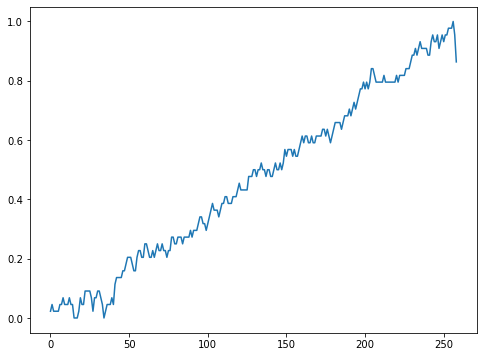

In [54]:
df['Resistance'].plot()

In [55]:
MAX_EPOCHS = 200
OUT_STEPS = 24

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [72]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    #tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [86]:
#x_train = tf.ragged.constant(x_train)
#y_train = tf.ragged.constant(y_train)
#x_valid = tf.ragged.constant(x_valid)
#y_valid = tf.ragged.constant(y_valid)

In [87]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      #  patience=500,
                                                       # mode='min')

#model.compile(loss=tf.losses.MeanSquaredError(),
 #            optimizer=tf.optimizers.Adam(),
  #           metrics=[tf.metrics.MeanAbsoluteError()])
    
history = model.fit(x_train, y_train, epochs=20,
                        validation_data=(x_valid, y_valid))

Epoch 1/20


ValueError: in user code:

    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected ndim=3, found ndim=7. Full shape received: (None, None, None, None, None, None, None)


In [ ]:
pred = model.predict(test_df)

In [251]:
IPython.display.clear_output()

multi_val_performance = model.evaluate(multi_window.val)
multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

F:\program\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:583: RuntimeWarning: divide by zero encountered in log10
  numdigits = int(np.log10(self.target)) + 1


OverflowError: cannot convert float infinity to integer